# **FINAL CM GROUP 7**

## **[1] Preparation**

### **Importing Libraries**

In [1]:
!pip install mediapipe

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import os
from tqdm import tqdm
import pickle
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# MediaPipe for face detection
import mediapipe as mp

# Scikit-learn for ML pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

# Scikit-image for LBP
from skimage.feature import local_binary_pattern

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"MediaPipe version: {mp.__version__}")

✓ All libraries imported successfully!
OpenCV version: 4.11.0
MediaPipe version: 0.10.21


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Project Configurations**

In [3]:
CONFIG = {
    'DATASET_SOURCES': {
        'masked': Path('/content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/MASKED'),
        'unmasked': Path('/content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/UNMASKED'),
    },
    'DATASET_LIMIT': 100,
    'USE_BOTH_SOURCES': True,
    'MODEL_PATH': Path('models'),
    'FACE_DETECTION_CONFIDENCE': 0.5,
    'EYE_ROI_TARGET_SIZE': (96, 32),
    'NEIGHBORS': 12,
}

# Create directories
CONFIG['MODEL_PATH'].mkdir(parents=True, exist_ok=True)

# Eye landmark indices
LEFT_EYE_INDICES = [33, 133, 160, 159, 158, 157, 173]  # Left eye contour
RIGHT_EYE_INDICES = [362, 263, 387, 386, 385, 384, 398]  # Right eye contour

FACE_OVAL_INDICES = [
    10, 338, 297, 332, 284, 251, 389, 356, 454,
    323, 361, 288, 397, 365, 379, 378, 400, 377,
    152, 148, 176, 149, 150, 136, 172, 58, 132,
    93, 234, 127, 162, 21, 54, 103, 67, 109
]


# Initialize MediaPipe Face Mesh (global)
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=CONFIG['FACE_DETECTION_CONFIDENCE']
)

print("✓ Configuration loaded!")
print(f"Dataset sources:")
for name, path in CONFIG['DATASET_SOURCES'].items():
    print(f"  {name}: {path}")
print(f"Use both sources: {CONFIG['USE_BOTH_SOURCES']}")

✓ Configuration loaded!
Dataset sources:
  masked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/MASKED
  unmasked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/UNMASKED
Use both sources: True


### **Helper Functions**

In [ ]:
def log(msg):
    """
    Fungsi untuk menampilkan pesan log dengan timestamp
    
    Parameter:
        msg: Pesan yang akan ditampilkan
    """
    from datetime import datetime
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"[{timestamp}] {msg}")

print("✓ Helper functions defined!")

✓ Helper functions defined!


## **[2] Loading Dataset**

In [ ]:
def load_dataset(dataset_sources, use_both=True, limit=50):
    """
    Memuat dataset gambar dari folder yang telah ditentukan
    
    Parameter:
        dataset_sources: Dictionary berisi path ke folder masked dan unmasked
        use_both: Boolean untuk menggunakan kedua sumber data (masked & unmasked)
        limit: Jumlah maksimal gambar per folder (default: 50)
    
    Return:
        all_image_paths: List berisi path semua gambar
        all_labels: List berisi label ID untuk setiap gambar
        label_to_id: Dictionary mapping nama orang ke ID numerik
    """
    # Tentukan sumber data yang akan dimuat
    sources_to_load = ['masked']
    if use_both and 'unmasked' in dataset_sources:
        sources_to_load.append('unmasked')

    log(f"Loading from sources: {sources_to_load}")

    person_images = {}

    # Loop untuk setiap sumber data (masked/unmasked)
    for source_name in sources_to_load:
        if source_name not in dataset_sources:
            continue

        source_path = Path(dataset_sources[source_name])

        if not source_path.exists():
            log(f"⚠ Warning: {source_name} path does not exist: {source_path}")
            continue

        log(f"\nScanning {source_name}: {source_path}")

        # Dapatkan semua folder orang dalam sumber data
        person_folders = sorted([d for d in source_path.iterdir() if d.is_dir()])
        log(f"  Found {len(person_folders)} person folders")

        for person_dir in person_folders:
            person_name = person_dir.name

            # Ambil semua file gambar (jpg, png, jpeg)
            image_files = list(person_dir.glob('*.jpg')) + \
                          list(person_dir.glob('*.png')) + \
                          list(person_dir.glob('*.jpeg'))

            # Batasi jumlah gambar sesuai parameter limit
            image_files = image_files[:limit]

            if person_name not in person_images:
                person_images[person_name] = []

            person_images[person_name].extend(image_files)

    # Buat mapping dari nama orang ke ID numerik
    label_to_id = {name: idx for idx, name in enumerate(sorted(person_images.keys()))}

    # Flatten data menjadi list path gambar dan list label
    all_image_paths = []
    all_labels = []

    for person_name, img_paths in person_images.items():
        label_id = label_to_id[person_name]
        for img_path in img_paths:
            all_image_paths.append(img_path)
            all_labels.append(label_id)

    return all_image_paths, all_labels, label_to_id





## **[3] Face Detection, Alignment, and Upper Face Extraction**

In [ ]:
def get_eye_center(landmarks, image_shape, eye_indices):
    """
    Menghitung titik tengah mata dari landmark yang terdeteksi
    
    Parameter:
        landmarks: List landmark wajah dari MediaPipe
        image_shape: Ukuran gambar (height, width)
        eye_indices: Indeks landmark untuk mata tertentu
    
    Return:
        center: Koordinat [x, y] titik tengah mata
    """
    h, w = image_shape[:2]
    pts = []

    # Konversi landmark yang dinormalisasi ke koordinat pixel
    for idx in eye_indices:
        x = int(landmarks[idx].x * w)
        y = int(landmarks[idx].y * h)
        pts.append([x, y])

    pts = np.array(pts)
    center = np.mean(pts, axis=0)  # Hitung rata-rata posisi

    return np.array([int(center[0]), int(center[1])])

def crop_eye_roi(image, landmarks):
    """
    Memotong region mata dari gambar wajah
    
    Parameter:
        image: Gambar wajah input
        landmarks: List landmark wajah dari MediaPipe
    
    Return:
        eye_crop: Gambar region mata yang telah dipotong
    """
    h, w = image.shape[:2]
    # Konversi semua landmark ke koordinat pixel
    pts = np.array([[int(l.x * w), int(l.y * h)] for l in landmarks])

    # Ambil titik landmark untuk mata kiri dan kanan
    left_eye_pts = pts[LEFT_EYE_INDICES]
    right_eye_pts = pts[RIGHT_EYE_INDICES]

    # Gabungkan kedua mata
    eyes = np.vstack([left_eye_pts, right_eye_pts])

    # Dapatkan bounding box di sekitar region mata
    x_min, y_min = eyes.min(axis=0)
    x_max, y_max = eyes.max(axis=0)

    # Tambahkan margin di sekitar mata untuk konteks lebih baik
    margin_x = int((x_max - x_min) * 0.1)   # 10% margin horizontal
    margin_y = int((y_max - y_min) * 1.75)  # 175% margin vertikal (untuk alis)

    # Pastikan tidak keluar dari batas gambar
    x_min = max(0, x_min - margin_x)
    y_min = max(0, y_min - margin_y)
    x_max = min(w, x_max + margin_x)
    y_max = min(h, y_max + margin_y)

    # Potong region mata dari gambar
    eye_crop = image[y_min:y_max, x_min:x_max]

    if eye_crop.size == 0:
        return None

    return eye_crop

In [ ]:
def face_detection_pipeline(image_path):
    """
    Pipeline untuk mendeteksi wajah, alignment, dan crop region mata
    
    Parameter:
        image_path: Path ke file gambar
    
    Return:
        eye_roi_image: Gambar region mata yang telah di-align dan di-crop
    """
    # Load gambar dari file
    image = cv2.imread(str(image_path))
    if image is None:
        return None

    # Konversi ke RGB untuk MediaPipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Deteksi wajah menggunakan MediaPipe Face Mesh
    results = face_mesh.process(image_rgb)

    # Cek apakah wajah terdeteksi
    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0].landmark

    # Dapatkan posisi titik tengah mata kiri dan kanan
    left_eye = get_eye_center(landmarks, image.shape, LEFT_EYE_INDICES)
    right_eye = get_eye_center(landmarks, image.shape, RIGHT_EYE_INDICES)

    # Hitung sudut rotasi dari posisi mata untuk alignment
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Lakukan alignment hanya jika sudut rotasi signifikan (> 2 derajat)
    if abs(angle) > 2.0:
        h, w = image.shape[:2]
        # Titik tengah antara kedua mata sebagai pusat rotasi
        eye_center = (
            float((left_eye[0] + right_eye[0]) / 2),
            float((left_eye[1] + right_eye[1]) / 2)
        )

        # Buat matriks transformasi affine untuk rotasi
        M = cv2.getRotationMatrix2D(eye_center, angle, 1.0)

        # Terapkan rotasi pada gambar
        aligned = cv2.warpAffine(
            image, M,
            (w, h),
            flags=cv2.INTER_CUBIC
        )

        # Transform landmark menggunakan matriks affine yang sama
        aligned_landmarks = []
        for lm in landmarks:
            x = lm.x * w
            y = lm.y * h
            # Terapkan transformasi affine
            new_x = M[0, 0] * x + M[0, 1] * y + M[0, 2]
            new_y = M[1, 0] * x + M[1, 1] * y + M[1, 2]

            # Buat objek landmark baru dengan koordinat yang sudah di-transform
            aligned_lm = type('Landmark', (), {
                'x': new_x / w,  # Normalisasi kembali
                'y': new_y / h
            })()
            aligned_landmarks.append(aligned_lm)

        landmarks = aligned_landmarks
    else:
        # Tidak perlu alignment jika sudut kecil
        aligned = image

    # Crop region mata dari gambar yang sudah di-align
    eye_roi_image = crop_eye_roi(aligned, landmarks)

    return eye_roi_image

## **[4] Preprocessing**

In [ ]:
def preprocessing_pipeline(eye_roi_image, target_size=(160, 160)):
    """
    Pipeline preprocessing untuk meningkatkan kualitas gambar
    
    Parameter:
        eye_roi_image: Gambar region mata
        target_size: Ukuran target untuk resize (default: 160x160)
    
    Return:
        denoised_image: Gambar yang telah diproses
    """
    # 1. Resize gambar ke ukuran target
    resized_image = cv2.resize(eye_roi_image, target_size, interpolation=cv2.INTER_CUBIC)

    # 2. Konversi ke grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # 3. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    #    Meningkatkan kontras lokal tanpa over-amplification
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # 4. Gaussian blur untuk mengurangi noise
    denoised_image = cv2.GaussianBlur(enhanced_image, (3, 3), 0)

    return denoised_image

In [ ]:
def augmenting_pipeline(image, n_aug=8):
    """
    Pipeline augmentasi data untuk meningkatkan variasi dataset
    
    Parameter:
        image: Gambar input
        n_aug: Jumlah variasi augmentasi yang akan dibuat (default: 8)
    
    Return:
        augmented: List berisi gambar asli + semua hasil augmentasi
    """
    augmented = [image]  # Simpan gambar asli
    h, w = image.shape

    for _ in range(n_aug):
        aug = image.copy()

        # 1. Variasi brightness (kecerahan) yang lebih agresif
        brightness = np.random.uniform(-40, 40)
        aug = np.clip(aug.astype(np.float32) + brightness, 0, 255).astype(np.uint8)

        # 2. Penyesuaian contrast
        alpha = np.random.uniform(0.8, 1.2)
        aug = np.clip(alpha * aug, 0, 255).astype(np.uint8)

        # 3. Tambahkan noise secara acak (30% kemungkinan)
        if np.random.rand() > 0.7:
            noise = np.random.normal(0, 5, aug.shape)
            aug = np.clip(aug + noise, 0, 255).astype(np.uint8)

        # 4. Gaussian blur (40% kemungkinan)
        if np.random.rand() > 0.6:
            aug = cv2.GaussianBlur(aug, (3, 3), 0)

        # 5. Horizontal flip - valid untuk mata (50% kemungkinan)
        if np.random.rand() > 0.5:
            aug = cv2.flip(aug, 1)

        # 6. Rotasi kecil (-5 hingga 5 derajat)
        angle = np.random.uniform(-5, 5)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        aug = cv2.warpAffine(aug, M, (w, h), borderMode=cv2.BORDER_REFLECT)

        # 7. Scale dan translasi kecil
        scale = np.random.uniform(0.92, 1.08)
        M2 = np.array([[scale, 0, np.random.uniform(-5, 5)],
                       [0, scale, np.random.uniform(-5, 5)]], dtype=np.float32)
        aug = cv2.warpAffine(aug, M2, (w, h), borderMode=cv2.BORDER_REFLECT)

        augmented.append(aug)

    return augmented

## **[5] Feature Extraction**

In [ ]:
def feature_extraction_pipeline(equalized_image, grid_size=(4, 4)):
    """
    Ekstraksi fitur menggunakan multi-scale LBP (Local Binary Pattern)
    
    Parameter:
        equalized_image: Gambar yang telah di-preprocessing
        grid_size: Ukuran grid untuk membagi gambar (default: 4x4)
    
    Return:
        features: Array 1D berisi semua fitur LBP yang telah di-concatenate
    """
    features_list = []

    # Konfigurasi multi-scale LBP dengan berbagai radius dan points
    lbp_configs = [
        (1, 8),   # Fine details - detail halus
        (2, 16),  # Medium details - detail menengah
        (3, 24),  # Coarse details - detail kasar
    ]

    # Ekstrak fitur untuk setiap skala
    for radius, n_points in lbp_configs:
        n_bins = n_points + 2  # Jumlah bin untuk histogram
        
        # Hitung LBP uniform pattern
        lbp = local_binary_pattern(equalized_image, n_points, radius, method='uniform')

        h, w = equalized_image.shape
        grid_y, grid_x = grid_size
        cell_h, cell_w = h // grid_y, w // grid_x

        cell_features = []

        # Bagi gambar menjadi grid dan ekstrak histogram dari setiap cell
        for gy in range(grid_y):
            for gx in range(grid_x):
                # Tentukan batas cell
                y0, y1 = gy * cell_h, (gy + 1) * cell_h if gy < grid_y - 1 else h
                x0, x1 = gx * cell_w, (gx + 1) * cell_w if gx < grid_x - 1 else w

                # Ambil LBP dari cell
                cell_lbp = lbp[y0:y1, x0:x1]
                
                # Hitung histogram dengan normalisasi densitas
                hist, _ = np.histogram(cell_lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

                # L2 normalization untuk invariance terhadap pencahayaan
                norm = np.linalg.norm(hist)
                if norm > 1e-7:
                    hist = hist / norm

                cell_features.append(hist)

        # Gabungkan semua histogram dari grid untuk skala ini
        features_list.append(np.concatenate(cell_features))

    # Gabungkan fitur dari semua skala menjadi satu vektor fitur
    return np.concatenate(features_list)

## **[6] Classification**

In [ ]:
def knn_fit(X_train, y_train, k=5, metric="cosine", weights="distance"):
    """
    Melatih model KNN classifier
    
    Parameter:
        X_train: Fitur training
        y_train: Label training
        k: Jumlah tetangga terdekat (default: 5)
        metric: Metrik jarak (default: cosine)
        weights: Bobot tetangga (default: distance)
    
    Return:
        knn: Model KNN yang telah dilatih
    """
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn.fit(X_train, y_train)

    train_score = knn.score(X_train, y_train)
    print(f"KNN Training Score: {train_score:.4f}")
    return knn

def evaluate_knn(knn, X_test, y_test, label_to_id):
    """
    Evaluasi model KNN secara komprehensif
    
    Parameter:
        knn: Model KNN yang telah dilatih
        X_test: Fitur testing
        y_test: Label testing
        label_to_id: Dictionary mapping nama ke ID
    
    Return:
        accuracy: Akurasi model pada test set
        y_pred: Prediksi label untuk test set
    """
    y_pred = knn.predict(X_test)

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)

    print("=" * 60)
    print("EVALUASI MODEL KNN")
    print("=" * 60)
    print(f"Akurasi Test: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("-" * 60)

    # Classification report untuk kelas-kelas teratas
    id_to_label = {v: k for k, v in label_to_id.items()}
    target_names = [id_to_label[i] for i in sorted(set(y_test))]

    print("\nClassification Report (sample):")
    print(classification_report(y_test, y_pred, target_names=target_names,
                                labels=sorted(set(y_test))[:10], zero_division=0))

    return accuracy, y_pred

def cross_validate_knn(X, y, k=5, cv=5):
    """
    Melakukan cross-validation pada model KNN
    
    Parameter:
        X: Fitur dataset
        y: Label dataset
        k: Jumlah tetangga (default: 5)
        cv: Jumlah fold untuk cross-validation (default: 5)
    
    Return:
        scores: Array berisi skor akurasi untuk setiap fold
    """
    log(f"Performing {cv}-fold cross-validation...")

    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', weights='distance')
    scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')

    print(f"\nCross-Validation Scores: {scores}")
    print(f"Mean CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    return scores

print("✓ Classification functions defined!")

✓ Classification functions defined!


## **[7] Visualization**

In [ ]:
def plot_class_distribution(labels, label_to_id, top_n=20):
    """
    Visualisasi distribusi jumlah sampel per kelas
    
    Parameter:
        labels: List label dari dataset
        label_to_id: Dictionary mapping nama ke ID
        top_n: Jumlah kelas teratas yang ditampilkan (default: 20)
    """
    id_to_label = {v: k for k, v in label_to_id.items()}
    label_names = [id_to_label[l] for l in labels]

    from collections import Counter
    counts = Counter(label_names)

    # Ambil top N kelas dengan sampel terbanyak
    top_classes = counts.most_common(top_n)
    names, values = zip(*top_classes)

    # Buat visualisasi bar chart
    plt.figure(figsize=(16, 6))
    bars = plt.bar(range(len(names)), values, color='#3498db', edgecolor='#2c3e50', 
                   alpha=0.85, linewidth=1.5)
    
    plt.xlabel('Nama Orang', fontsize=13, fontweight='bold')
    plt.ylabel('Jumlah Gambar', fontsize=13, fontweight='bold')
    plt.title(f'Top {top_n} Kelas Berdasarkan Jumlah Sampel (Total: {len(label_to_id)} kelas)',
              fontsize=15, fontweight='bold', pad=20)
    plt.xticks(range(len(names)), names, rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Tambahkan label nilai di atas setiap bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Tampilkan statistik
    print(f"\n{'='*50}")
    print(f"Total sampel: {len(labels)}")
    print(f"Total kelas: {len(label_to_id)}")
    print(f"Rata-rata sampel per kelas: {len(labels)/len(label_to_id):.2f}")
    print(f"{'='*50}\n")

def visualize_feature_samples(images, labels, label_to_id, n_samples=10):
    """
    Visualisasi sampel acak dari dataset
    
    Parameter:
        images: List gambar
        labels: List label
        label_to_id: Dictionary mapping nama ke ID
        n_samples: Jumlah sampel yang ditampilkan (default: 10)
    """
    id_to_label = {v: k for k, v in label_to_id.items()}

    # Pilih indeks secara acak
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    rows = 2
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(18, 7))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < len(indices):
            img_idx = indices[idx]
            img = images[img_idx]
            label_id = labels[img_idx]
            person_name = id_to_label[label_id]

            # Tampilkan gambar
            if len(img.shape) == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap='gray')

            # Potong nama jika terlalu panjang
            display_name = person_name[:20] + '...' if len(person_name) > 20 else person_name
            ax.set_title(f"{display_name}", fontsize=11, fontweight='bold', pad=8)
            
            # Tambahkan border
            for spine in ax.spines.values():
                spine.set_edgecolor('#2c3e50')
                spine.set_linewidth(2)
        
        ax.axis('off')

    plt.suptitle('Contoh Gambar Acak dari Dataset', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, label_to_id, top_n=15):
    """
    Visualisasi confusion matrix untuk kelas-kelas teratas
    
    Parameter:
        y_true: Label sebenarnya
        y_pred: Label prediksi
        label_to_id: Dictionary mapping nama ke ID
        top_n: Jumlah kelas yang ditampilkan (default: 15)
    """
    id_to_label = {v: k for k, v in label_to_id.items()}

    # Ambil top N kelas paling umum
    from collections import Counter
    class_counts = Counter(y_true)
    top_classes = [cls for cls, _ in class_counts.most_common(top_n)]

    # Filter prediksi untuk top classes saja
    mask = np.isin(y_true, top_classes)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    # Buat confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)

    # Normalisasi
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Visualisasi
    plt.figure(figsize=(14, 11))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[id_to_label[i][:15] for i in top_classes],
                yticklabels=[id_to_label[i][:15] for i in top_classes],
                cbar_kws={'label': 'Akurasi'}, linewidths=0.5, linecolor='gray')
    
    plt.title(f'Confusion Matrix (Normalized) - Top {top_n} Kelas',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Label Sebenarnya', fontsize=13, fontweight='bold')
    plt.xlabel('Label Prediksi', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_feature_dimensionality(features_original, features_reduced, variance_explained=None):
    """
    Visualisasi perbandingan dimensi fitur sebelum dan sesudah reduksi
    
    Parameter:
        features_original: Fitur asli sebelum reduksi
        features_reduced: Fitur setelah reduksi (PCA)
        variance_explained: Proporsi variance yang dipertahankan
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Grafik fitur asli
    axes[0].bar(['Fitur Asli'], [features_original.shape[1]],
                color='#e74c3c', edgecolor='#c0392b', alpha=0.8, width=0.5, linewidth=2)
    axes[0].set_ylabel('Jumlah Fitur', fontsize=13, fontweight='bold')
    axes[0].set_title('Dimensi Fitur Asli', fontsize=14, fontweight='bold', pad=15)
    axes[0].text(0, features_original.shape[1] + 20, f'{features_original.shape[1]} dims',
                ha='center', va='bottom', fontsize=16, fontweight='bold')
    axes[0].set_ylim(0, features_original.shape[1] * 1.15)
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')

    # Grafik fitur hasil reduksi
    axes[1].bar(['Fitur PCA'], [features_reduced.shape[1]],
                color='#27ae60', edgecolor='#229954', alpha=0.8, width=0.5, linewidth=2)
    axes[1].set_ylabel('Jumlah Fitur', fontsize=13, fontweight='bold')
    axes[1].set_title('Dimensi Fitur Setelah PCA', fontsize=14, fontweight='bold', pad=15)
    axes[1].text(0, features_reduced.shape[1] + 20, f'{features_reduced.shape[1]} dims',
                ha='center', va='bottom', fontsize=16, fontweight='bold')
    axes[1].set_ylim(0, features_original.shape[1] * 1.15)
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')

    # Tambahkan info variance jika tersedia
    if variance_explained is not None:
        axes[1].text(0, features_reduced.shape[1] * 0.6,
                    f'Variance: {variance_explained:.1%}',
                    ha='center', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='#f39c12', alpha=0.7, 
                             edgecolor='#d68910', linewidth=2))

    # Tambahkan info reduksi
    reduction = (1 - features_reduced.shape[1]/features_original.shape[1]) * 100
    fig.text(0.5, 0.02, f'Reduksi Dimensi: {reduction:.1f}%', 
             ha='center', fontsize=13, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, 
                      edgecolor='black', linewidth=1.5))

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

def calculate_psnr_mse_val(img1, img2):
    """
    Menghitung PSNR (Peak Signal-to-Noise Ratio) dan MSE antara dua gambar
    
    Parameter:
        img1: Gambar pertama
        img2: Gambar kedua
    
    Return:
        psnr: Nilai PSNR dalam dB
        mse: Nilai Mean Squared Error
    """
    # Konversi ke grayscale jika perlu
    if len(img1.shape) == 3: 
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) == 3: 
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Hitung MSE
    mse = np.mean((img1 - img2) ** 2)
    
    # Jika MSE = 0, gambar identik
    if mse == 0:
        return float('inf'), 0
    
    # Hitung PSNR
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    
    return psnr, mse

print("✓ Visualization functions added!")

✓ Visualization functions added!


## **[8] Inference**

In [ ]:
def load_trained_model(model_path):
    """
    Memuat model yang telah dilatih dari file
    
    Parameter:
        model_path: Path ke file model (.pkl)
    
    Return:
        knn_model: Model KNN yang telah dilatih
        pca: Model PCA untuk reduksi dimensi
        scaler: StandardScaler untuk normalisasi
        label_to_id: Dictionary mapping nama ke ID
    """
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)

    log(f"✓ Model loaded successfully!")
    log(f"  Dimensi fitur asli: {model_data['config']['feature_dim_original']}")
    log(f"  Dimensi fitur PCA: {model_data['config']['feature_dim_pca']}")
    log(f"  Jumlah kelas: {len(model_data['label_to_id'])}")
    log(f"  Akurasi test: {model_data['config']['test_accuracy']:.4f}")

    return model_data['knn_model'], model_data['pca'], model_data['scaler'], model_data['label_to_id']

def inference_pipeline(image_path, model, pca, scaler, label_to_id, target_size=(96, 32)):
    """
    Pipeline inferensi lengkap untuk pengenalan wajah dengan visualisasi detail
    
    Parameter:
        image_path: Path ke gambar yang akan diprediksi
        model: Model KNN yang telah dilatih
        pca: Model PCA untuk reduksi dimensi
        scaler: StandardScaler untuk normalisasi
        label_to_id: Dictionary mapping nama ke ID
        target_size: Ukuran target untuk preprocessing
    """
    # ========== TAHAP 1: Load Gambar Asli ==========
    original = cv2.imread(str(image_path))
    if original is None:
        print(f"Gagal memuat gambar: {image_path}")
        return
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # ========== TAHAP 2: Deteksi Wajah & Ekstraksi ROI ==========
    roi = face_detection_pipeline(image_path)
    if roi is None:
        print(f'Tidak ada wajah terdeteksi dalam: {image_path}')
        return

    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    # ========== TAHAP 3: Preprocessing ==========
    resized = cv2.resize(roi, target_size, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    processed = preprocessing_pipeline(roi, target_size)

    # Hitung kualitas gambar (PSNR & MSE)
    psnr, mse = calculate_psnr_mse_val(gray, processed)

    # ========== TAHAP 4: Ekstraksi Fitur LBP ==========
    radius = 3
    n_points = 24
    lbp_map = local_binary_pattern(processed, n_points, radius, method='uniform')

    # ========== TAHAP 5: Ekstraksi Fitur & Klasifikasi ==========
    feats = feature_extraction_pipeline(processed)
    feats = feats.reshape(1, -1)
    feats_scaled = scaler.transform(feats)
    feats_pca = pca.transform(feats_scaled)

    # Prediksi identitas
    pred_id = model.predict(feats_pca)[0]
    proba = model.predict_proba(feats_pca)
    confidence = np.max(proba)

    # Ambil top 3 prediksi
    top_3_idx = np.argsort(proba[0])[-3:][::-1]
    top_3_proba = proba[0][top_3_idx]

    id_to_label = {v: k for k, v in label_to_id.items()}
    pred_name = id_to_label[pred_id]
    top_3_names = [id_to_label[idx] for idx in top_3_idx]

    # ========== VISUALISASI PIPELINE ==========
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3, 
                          left=0.05, right=0.95, top=0.93, bottom=0.05)

    # 1. Gambar Asli
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original_rgb)
    ax1.set_title('① Gambar Asli', fontweight='bold', fontsize=13, pad=10)
    ax1.axis('off')

    # 2. Region Mata (ROI)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(roi_rgb)
    ax2.set_title('② Region Mata (ROI)', fontweight='bold', fontsize=13, pad=10)
    ax2.axis('off')

    # 3. Hasil Preprocessing
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(processed, cmap='gray')
    ax3.set_title(f'③ Preprocessing\nPSNR: {psnr:.2f} dB | MSE: {mse:.2f}', 
                  fontweight='bold', fontsize=13, pad=10)
    ax3.axis('off')

    # 4. LBP Feature Map
    ax4 = fig.add_subplot(gs[1, 0])
    lbp_display = ax4.imshow(lbp_map, cmap='viridis')
    ax4.set_title('④ Peta Fitur LBP', fontweight='bold', fontsize=13, pad=10)
    ax4.axis('off')
    plt.colorbar(lbp_display, ax=ax4, fraction=0.046, pad=0.04)

    # 5. Perbandingan Histogram
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(gray.ravel(), bins=64, range=(0, 256), alpha=0.7,
            label='Sebelum', color='#e74c3c', edgecolor='black', linewidth=0.5)
    ax5.hist(processed.ravel(), bins=64, range=(0, 256), alpha=0.7,
            label='Sesudah', color='#3498db', edgecolor='black', linewidth=0.5)
    ax5.set_xlabel('Intensitas Pixel', fontweight='bold', fontsize=11)
    ax5.set_ylabel('Frekuensi', fontweight='bold', fontsize=11)
    ax5.set_title('⑤ Perbandingan Histogram', fontweight='bold', fontsize=13, pad=10)
    ax5.legend(fontsize=10, loc='upper right')
    ax5.grid(alpha=0.3, linestyle='--')
    ax5.tick_params(labelsize=9)

    # 6. Hasil Prediksi
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')

    # Tentukan warna berdasarkan confidence
    if confidence >= 0.9:
        conf_color = '#27ae60'  # Hijau
        conf_text = 'Sangat Tinggi'
    elif confidence >= 0.7:
        conf_color = '#f39c12'  # Orange
        conf_text = 'Tinggi'
    elif confidence >= 0.5:
        conf_color = '#e67e22'  # Orange gelap
        conf_text = 'Sedang'
    else:
        conf_color = '#e74c3c'  # Merah
        conf_text = 'Rendah'

    # Title prediksi
    ax6.text(0.5, 0.95, '⑥ HASIL PREDIKSI', ha='center', va='top',
            fontsize=13, fontweight='bold', transform=ax6.transAxes)

    # Nama prediksi utama
    display_name = pred_name[:25] + '...' if len(pred_name) > 25 else pred_name
    ax6.text(0.5, 0.78, display_name, ha='center', va='center',
            fontsize=15, fontweight='bold', color=conf_color,
            transform=ax6.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                     edgecolor=conf_color, linewidth=2.5))

    # Confidence score
    ax6.text(0.5, 0.62, f'Confidence: {confidence*100:.2f}%', 
            ha='center', va='center',
            fontsize=11, fontweight='bold', color=conf_color,
            transform=ax6.transAxes)
    
    ax6.text(0.5, 0.54, f'({conf_text})', 
            ha='center', va='center',
            fontsize=10, style='italic', color=conf_color,
            transform=ax6.transAxes)

    # Top 3 predictions dalam box
    y_start = 0.42
    ax6.text(0.5, y_start, 'Top 3 Prediksi:', ha='center', va='center',
            fontsize=10, fontweight='bold', transform=ax6.transAxes,
            style='italic')
    
    for i, (name, prob) in enumerate(zip(top_3_names, top_3_proba)):
        display_n = name[:22] + '...' if len(name) > 22 else name
        y_pos = y_start - 0.08 - (i * 0.1)
        
        # Background untuk setiap prediksi
        if i == 0:
            bg_color = '#d5f4e6'  # Hijau muda untuk top 1
            edge_color = '#27ae60'
        else:
            bg_color = '#f8f9fa'  # Abu-abu muda untuk lainnya
            edge_color = '#bdc3c7'
            
        ax6.text(0.15, y_pos, f'{i+1}. {display_n}',
               ha='left', va='center', fontsize=9,
               transform=ax6.transAxes,
               bbox=dict(boxstyle='round,pad=0.3', facecolor=bg_color, 
                        edgecolor=edge_color, linewidth=1.5))
        ax6.text(0.85, y_pos, f'{prob*100:.1f}%',
               ha='right', va='center', fontsize=9, fontweight='bold',
               transform=ax6.transAxes)

    plt.suptitle('Pipeline Pengenalan Wajah', fontsize=16, fontweight='bold')
    plt.show()

    # ========== RINGKASAN HASIL ==========
    print("\n" + "="*70)
    print("RINGKASAN HASIL PENGENALAN".center(70))
    print("="*70)
    print(f"\nFile: {Path(image_path).name}")
    print(f"\n{'Identitas Terdeteksi:':<25} {pred_name}")
    print(f"{'Confidence:':<25} {confidence*100:.2f}% ({conf_text})")
    print(f"{'Class ID:':<25} {pred_id}")
    
    print(f"\n{'─'*70}")
    print("Top 3 Prediksi:")
    for i, (name, prob) in enumerate(zip(top_3_names, top_3_proba), 1):
        print(f"  {i}. {name[:45]:<45} {prob*100:.2f}%")
    
    print(f"\n{'─'*70}")
    print("Detail Teknis:")
    print(f"  • Dimensi Fitur Asli: {feats.shape[1]} dimensi")
    print(f"  • Dimensi Fitur PCA: {feats_pca.shape[1]} dimensi")
    print(f"  • Reduksi Dimensi: {(1-feats_pca.shape[1]/feats.shape[1])*100:.1f}%")
    print(f"  • PSNR: {psnr:.2f} dB")
    print(f"  • MSE: {mse:.2f}")
    print("="*70 + "\n")

    # Simpan fitur ke file CSV
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Save LBP features
    np.savetxt(
        f"{base_name}_lbp.csv",
        feats.reshape(1, -1),
        delimiter=",",
        fmt="%.6f"
    )

    # Save PCA features
    np.savetxt(
        f"{base_name}_pca.csv",
        feats_pca.reshape(1, -1),
        delimiter=",",
        fmt="%.6f"
    )

    print(f"✓ Fitur telah disimpan:")
    print(f"  • {base_name}_lbp.csv")
    print(f"  • {base_name}_pca.csv")

## **[STAR] Main Pipeline**

In [ ]:
def process_dataset(image_paths, labels):
    """
    Memproses seluruh dataset melalui pipeline:
    Face Detection → Preprocessing → Augmentasi
    
    Parameter:
        image_paths: List path ke semua gambar
        labels: List label untuk setiap gambar
    
    Return:
        processed_images: List gambar yang telah diproses (termasuk augmentasi)
        processed_labels: List label yang sesuai dengan gambar hasil augmentasi
    """
    log("STEP 02 & 03: Face Detection → Preprocessing → Augmentasi")

    processed_images = []
    processed_labels = []

    for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Dataset")):
        # --- TAHAP 1: Deteksi Wajah ---
        eye_roi_image = face_detection_pipeline(image_path)
        if eye_roi_image is None:
            continue  # Skip jika gagal mendeteksi wajah

        # --- TAHAP 2: Preprocessing ---
        equalized_image = preprocessing_pipeline(eye_roi_image, target_size=CONFIG['EYE_ROI_TARGET_SIZE'])

        # --- TAHAP 3: Augmentasi Data ---
        # Menghasilkan beberapa variasi dari gambar untuk meningkatkan dataset
        augmented = augmenting_pipeline(equalized_image)

        # Simpan semua hasil augmentasi dengan label yang sama
        label = labels[idx]
        processed_images.extend(augmented)
        processed_labels.extend([label] * len(augmented))

    log(f"✓ Selesai! Total {len(processed_images)} gambar berhasil diproses.")
    return processed_images, processed_labels

In [15]:
log("STEP 01: Loading Dataset")
image_paths, labels, label_to_id = load_dataset(CONFIG['DATASET_SOURCES'], CONFIG['USE_BOTH_SOURCES'], CONFIG['DATASET_LIMIT'])
log("✓ Done!")

[13:21:28] STEP 01: Loading Dataset
[13:21:28] Loading from sources: ['masked', 'unmasked']
[13:21:43] 
Scanning masked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/MASKED
[13:21:43]   Found 24 person folders
[13:21:50] 
Scanning unmasked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/UNMASKED
[13:21:50]   Found 24 person folders
[13:21:57] ✓ Done!


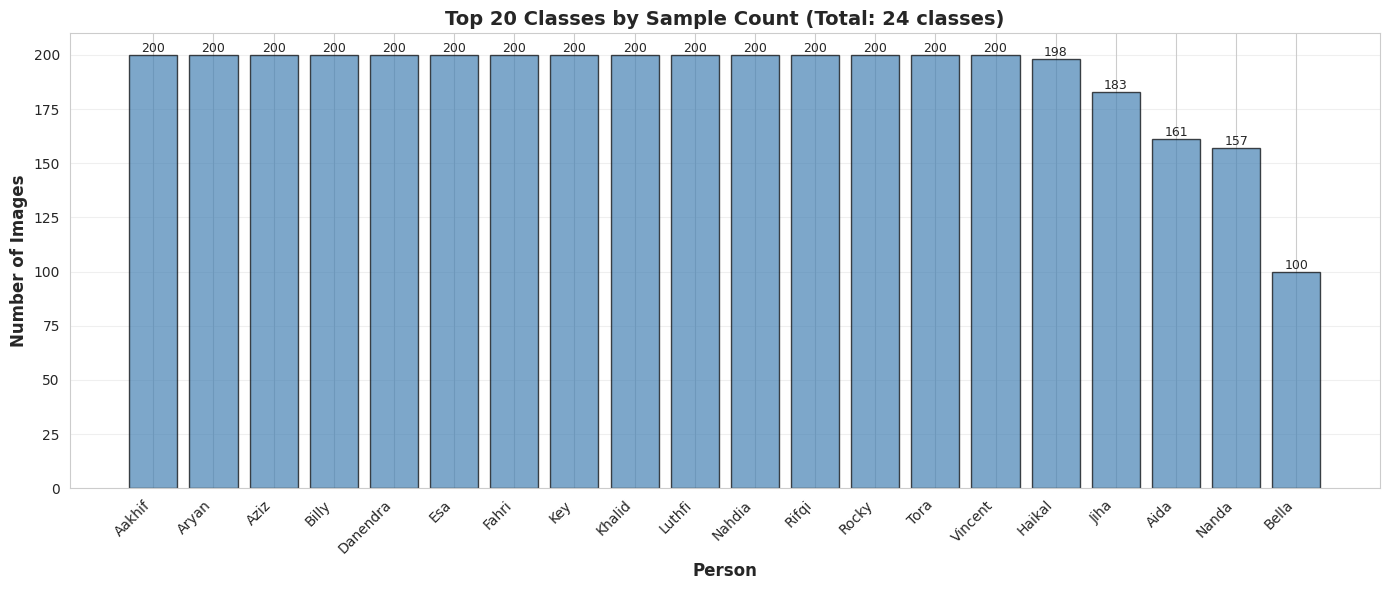

Total samples: 4151
Total classes: 24
Average samples per class: 172.96


In [16]:
plot_class_distribution(labels, label_to_id, top_n=20)

In [17]:
log("STEP 02 & 03: Processing Dataset")
processed_images, labels = process_dataset(image_paths, labels)
log("✓ All Face Detection, Preprocessing, and Augmentation Completed!")

[13:21:58] STEP 02 & 03: Processing Dataset
[13:21:58] STEP 02 & 03: Face Detection → Preprocessing → Augmentation


Processing Dataset: 100%|██████████| 4151/4151 [21:42<00:00,  3.19it/s]

[13:43:40] ✓ Done! Processed 37206 images total.
[13:43:40] ✓ All Face Detection, Preprocessing, and Augmentation Completed!


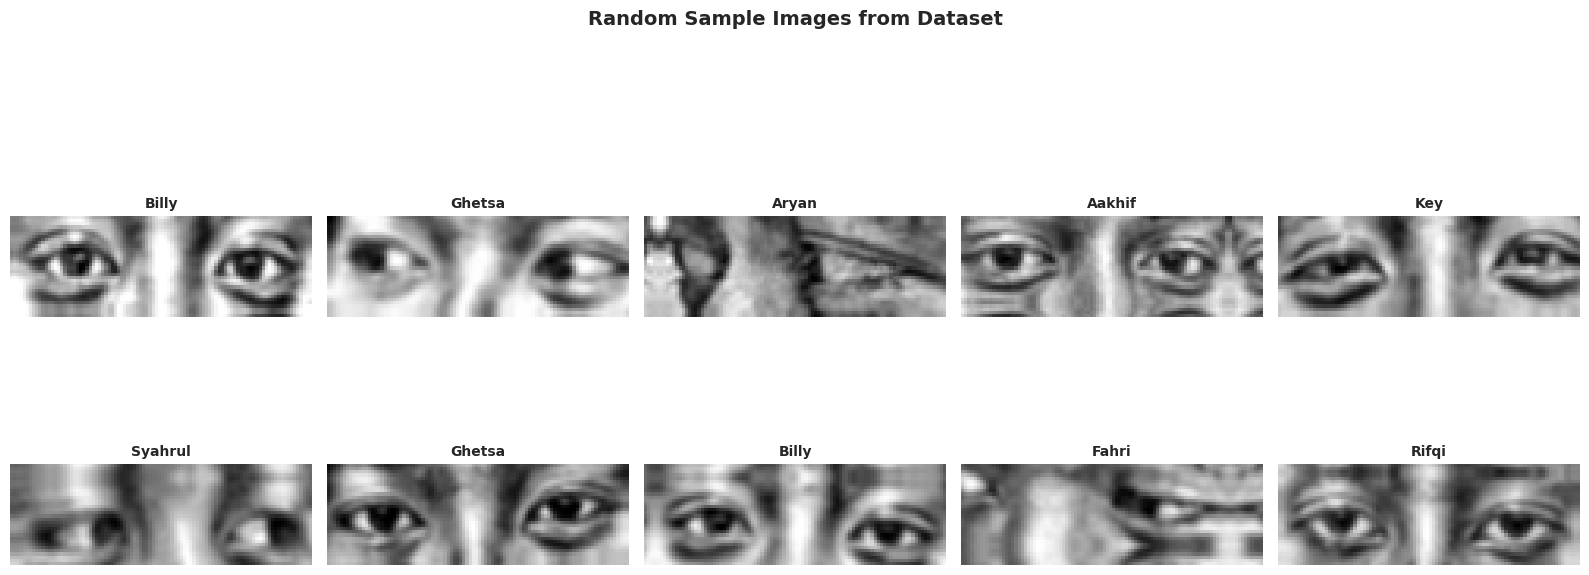

In [18]:
visualize_feature_samples(processed_images, labels, label_to_id, n_samples=10)

In [19]:
log("STEP 04: Feature Extraction")
features = []
for processed_image in tqdm(processed_images, desc="Extracting Features"):
    feature = feature_extraction_pipeline(processed_image)
    features.append(feature)

features = np.array(features)  # Convert to numpy array
log(f"✓ Done! Feature shape: {features.shape}")

[13:43:41] STEP 04: Feature Extraction


Extracting Features: 100%|██████████| 37206/37206 [07:32<00:00, 82.18it/s]


[13:51:14] ✓ Done! Feature shape: (37206, 864)


[14:14:27] STEP 05: Classification


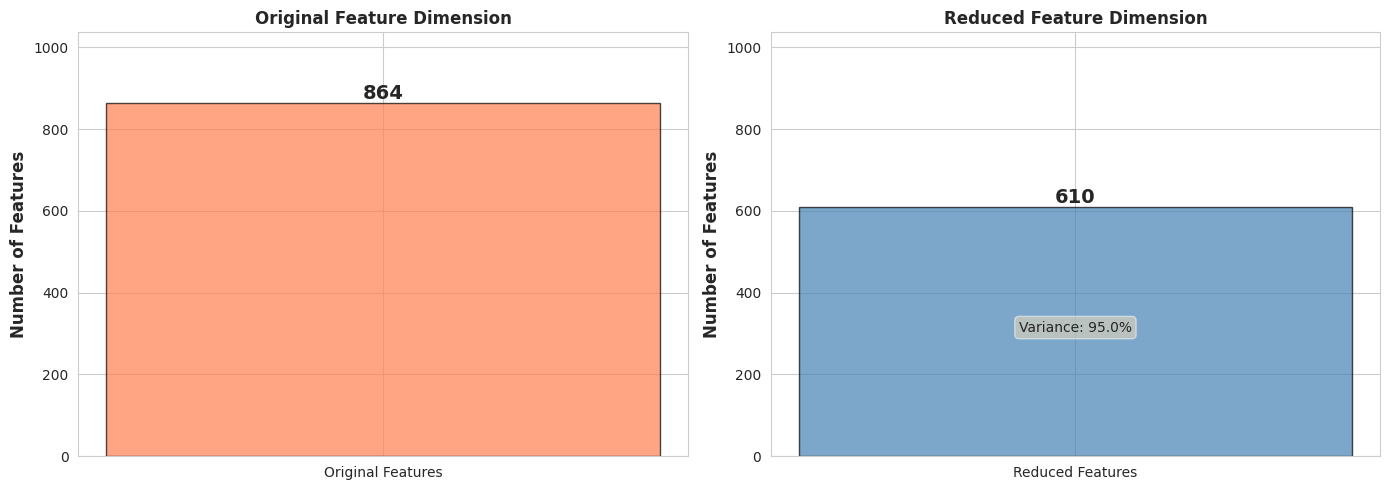

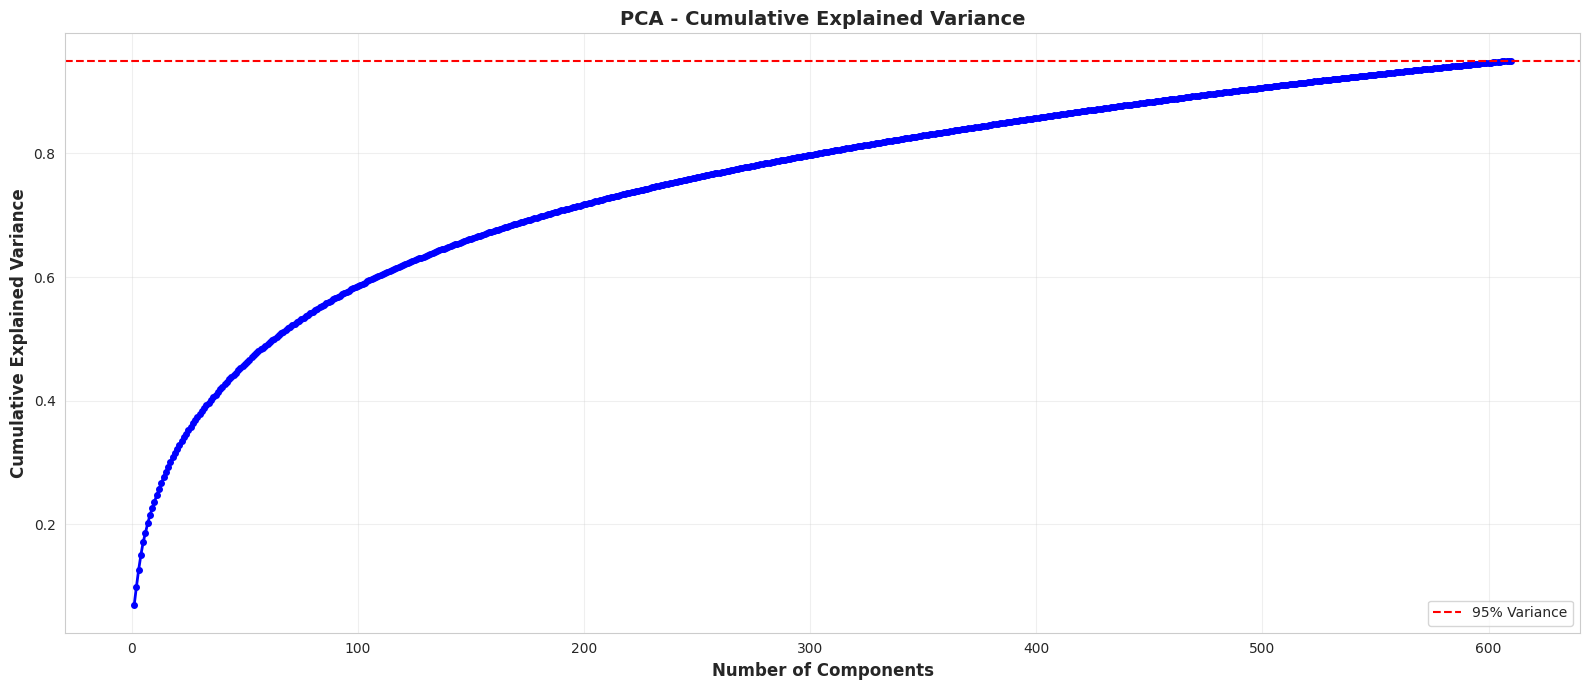

[14:14:30] Performing 5-fold cross-validation...

Cross-Validation Scores: [0.90828154 0.90055434 0.90391399 0.90324206 0.90658602]
Mean CV Accuracy: 0.9045 (+/- 0.0054)
KNN Training Score: 1.0000
KNN MODEL EVALUATION
Test Accuracy: 0.9144 (91.44%)
------------------------------------------------------------

Classification Report (sample):
              precision    recall  f1-score   support

      Aakhif       0.91      0.97      0.94       368
        Aida       0.93      0.88      0.91       295
       Aryan       0.86      0.84      0.85       334
        Aziz       0.90      0.91      0.90       380
       Bella       0.96      0.72      0.82       179
       Billy       0.93      0.92      0.93       372
    Danendra       0.97      0.91      0.94       342
         Esa       0.95      0.88      0.91       368
       Fahri       0.91      0.97      0.94       366
      Ghetsa       0.92      0.93      0.92       168

   micro avg       0.92      0.90      0.91      3172
   macr

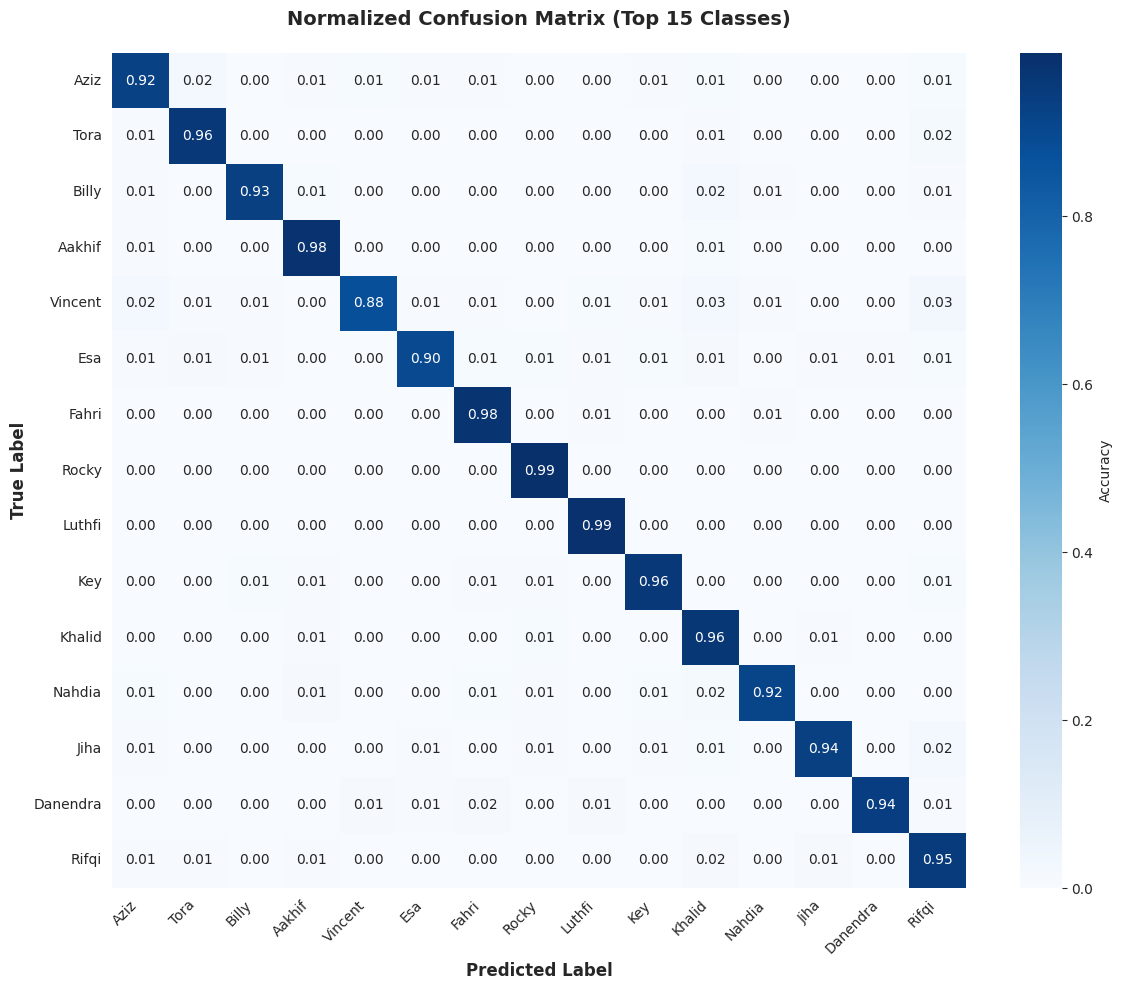

[14:16:27] ✓ Done!


In [36]:
log("STEP 05: Classification")

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

variance_explained = np.sum(pca.explained_variance_ratio_)

# Visualize dimensionality reduction
plot_feature_dimensionality(X_train, X_train_pca, variance_explained)

# Plot cumulative explained variance
plt.figure(figsize=(16, 7))
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'b-o', linewidth=2, markersize=4)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
plt.title('PCA - Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Cross-validation on training set
cv_scores = cross_validate_knn(X_train_pca, y_train, k=CONFIG['NEIGHBORS'], cv=5)

# Train the model
knn = knn_fit(X_train_pca, y_train, k=CONFIG['NEIGHBORS'], metric='cosine', weights='distance')

# Evaluate the model
test_accuracy, y_pred = evaluate_knn(knn, X_test_pca, y_test, label_to_id)
plot_confusion_matrix(y_test, y_pred, label_to_id, top_n=15)
log("✓ Done!")

In [37]:
# Save the trained model and label mapping
log("Saving model and label mapping...")

model_data = {
    'knn_model': knn,
    'pca': pca,
    'scaler': scaler,
    'label_to_id': label_to_id,
    'config': {
        'k': CONFIG['NEIGHBORS'],
        'metric': 'cosine',
        'weights': 'distance',
        'feature_dim_original': X_train.shape[1],
        'feature_dim_pca': X_train_pca.shape[1],
        'variance_explained': variance_explained,
        'test_accuracy': test_accuracy
    }
}

with open(CONFIG['MODEL_PATH'] / 'knn_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

log("✓ Model saved successfully!")
log(f"  File: {CONFIG['MODEL_PATH'] / 'knn_model.pkl'}")
log(f"  Test Accuracy: {test_accuracy:.4f}")

[14:16:27] Saving model and label mapping...
[14:16:27] ✓ Model saved successfully!
[14:16:27]   File: models/knn_model.pkl
[14:16:27]   Test Accuracy: 0.9144


[14:22:59] STEP 06: Inference
[14:22:59] Processing test image: esa_test.jpg


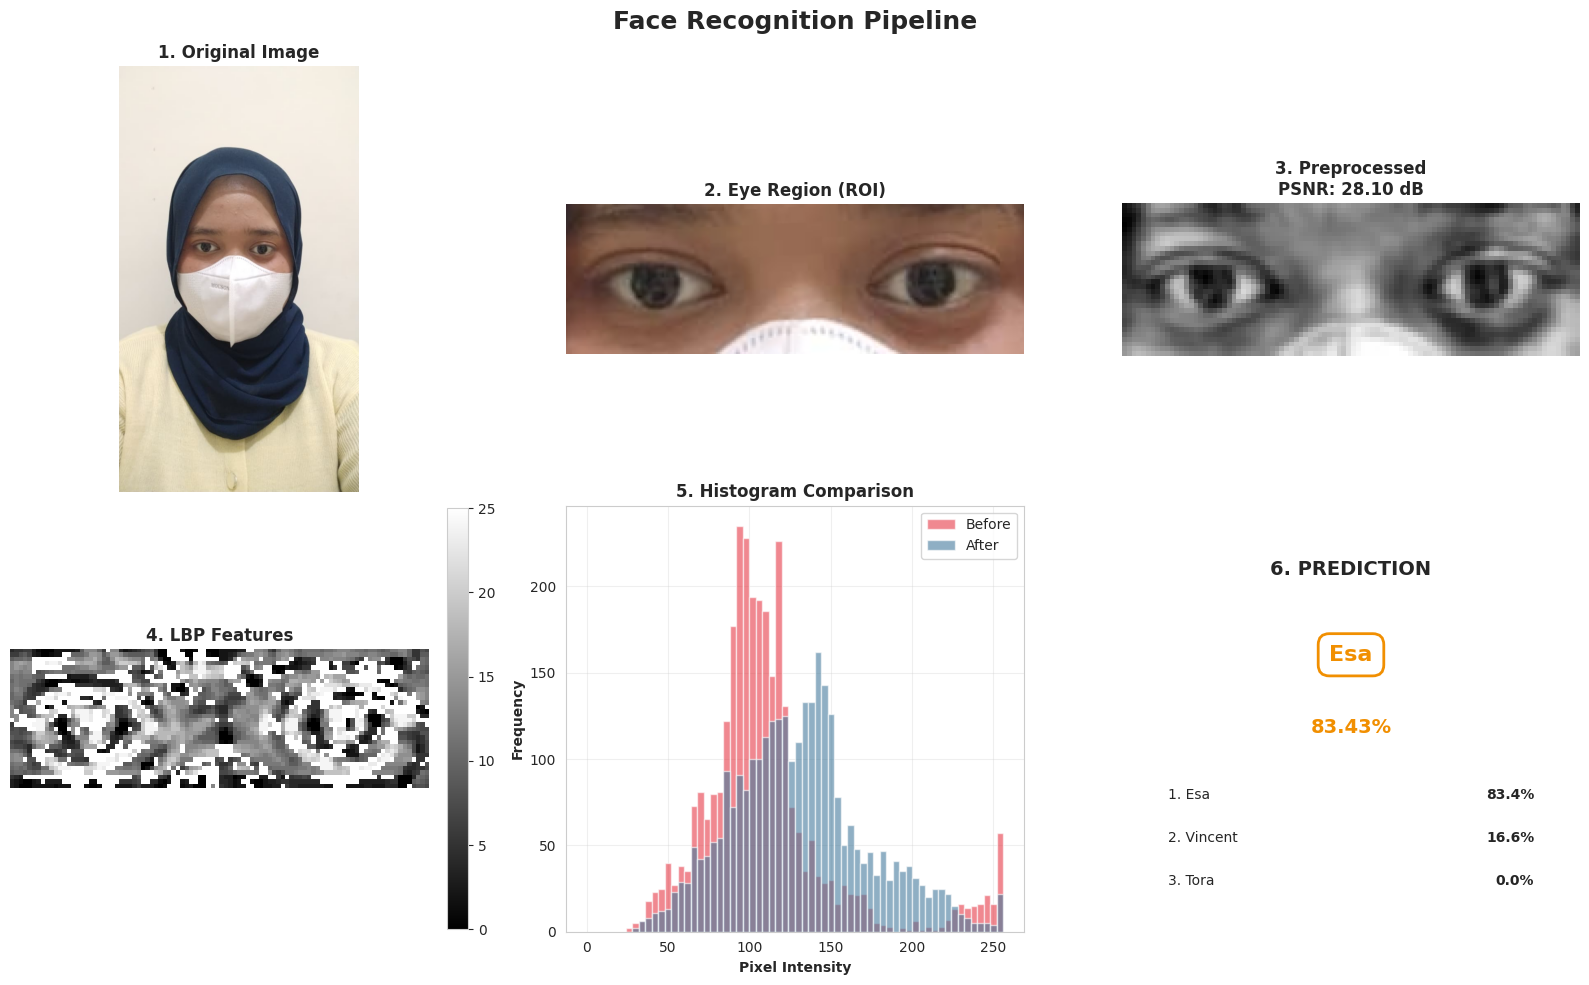


                    RECOGNITION RESULTS                     

Image: esa_test.jpg

Predicted Identity: Esa
Confidence: 83.43%
Class ID: 7

Image Quality:
  PSNR: 28.10 dB
  MSE: 100.65

Feature Dimensions:
  Original: 864 dims
  PCA: 610 dims
  Reduction: 29.4%

Top 3 Predictions:
  1. Esa                                      83.43%
  2. Vincent                                  16.57%
  3. Tora                                     0.00%

[14:23:01] ✓ Done!


In [51]:
log("STEP 06: Inference")

image_test_path = "esa_test.jpg"

log(f"Processing test image: {image_test_path}")
inference_pipeline(image_test_path, knn, pca, scaler, label_to_id, CONFIG['EYE_ROI_TARGET_SIZE'])

log("✓ Done!")